In [7]:
#Required packages are imported here

#Preprocessing and vizualization
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sn
import matplotlib.gridspec as gridspec

from pathlib import Path
import cv2
from PIL import Image
from random import randint
from zipfile import ZipFile
import zipfile

import tensorflow.keras.optimizers as Optimizer
import tensorflow.keras.layers as Layers
import tensorflow.keras.models as Models
import tensorflow as tf
from tensorflow.keras import optimizers

#Optimization
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Conv2D, Activation, Dropout, Flatten, MaxPooling2D
from keras.models import Sequential, load_model, Model

#Accuracy Reports
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split


User Defined Fuctions 

Functions to read and display images using the 

In [8]:

#function to display images
def image_display(images, clas , row, column):
    plt.subplots_adjust(0,0,3,3)
    for i in range(0,row*column):
        random_number = randint(0, len(images))
        img = images[random_number]
        plt.subplot(row,column,i+1)
        plt.title(clas[random_number])
        plt.axis('off')
        plt.imshow(img)


# function to read images
def image_read(dir_data, dir_image):
    images=[]
    classes =[]
    if len(dir_image)!=0:
      for dir_img in dir_image:
          for path in Path(dir_data+'/'+dir_img).iterdir():
              if path.name.endswith('.jpg'):
                      img = cv2.imread(str(path))
                      img = cv2.resize(img,(150,150))  #Images can be of different size so resizing the images
                      images.append(img)
                      classes.append(dir_img)
    elif len(dir_image) == 0:
      for path in Path(dir_data).iterdir():
              if path.name.endswith('.jpg'):
                      img = cv2.imread(str(path))
                      img = cv2.resize(img,(150,150))  #Images can be of different size so resizing the images
                      images.append(img)
    return images, classes




In [9]:
# Unzip files
def unzipfile(zipfile):
  with ZipFile(zipfile, 'r') as zipObj:
    zipObj.extractall()

# Encoder label function
def encoder_label(classes):
  class_dict ={'buildings':0, 'forest':1, 'glacier':2, 'mountain':3, 'sea':4, 'street':5}
  labels = [class_dict[item] for item in classes]
  return labels

#Decoder label fucntion
def decoder_label(class_code):
    labels = {2:'glacier', 4:'sea', 0:'buildings', 1:'forest', 5:'street', 3:'mountain', 6:'unknown'}
    return labels[class_code]


In [10]:
#Setting Early stopping Criteria

#Number of epochs without any imporvement , after which the training will stop
epochs = 2 
#Defining the early stopping
stop_early = EarlyStopping(monitor='val_loss', patience=epochs, verbose=1)


#Checkpoint --> A physical file is saved 
model_checkpoint = ModelCheckpoint('fas_mnist_1.h5', verbose=1, save_best_only=True)


#Cross Validation Function
def n_fold_cross_validation(n_folds, X, y, model):
  model_hist = []
  for i in range(n_folds):
      print("Fold currently training: ",i+1) 
      model_hist.append(model.fit(X, y, epochs=20, callbacks=[stop_early],
              verbose=1, validation_split=0.1))
      print("======="*12, end="\n\n\n")
  return model_hist

Training Images Visualizations

In [11]:
# Variables used in this task
dir_image = ['buildings','forest','glacier','mountain','sea','street']
dir_data = 'seg_train'

In [12]:
# unzipping training file

#Check if file is a zipfile
val = zipfile.is_zipfile('/content/sample_data/seg_train.zip')

if (val == True):
  unzipfile('/content/sample_data/seg_train.zip')
else:
  print("Given file is not a zipfile")

In [13]:
# Training set read images
train_images, train_classes = image_read('/content/seg_train/seg_train', dir_image)

In [14]:
# Converting the images to a numpy array
train_images = np.array(train_images)
train_classes = np.array(train_classes)

In [15]:
#Validating the images shapes and labels
print('Images Shape:', train_images.shape)
print('Classes Shape:', train_classes.shape)

Images Shape: (14034, 150, 150, 3)
Classes Shape: (14034,)


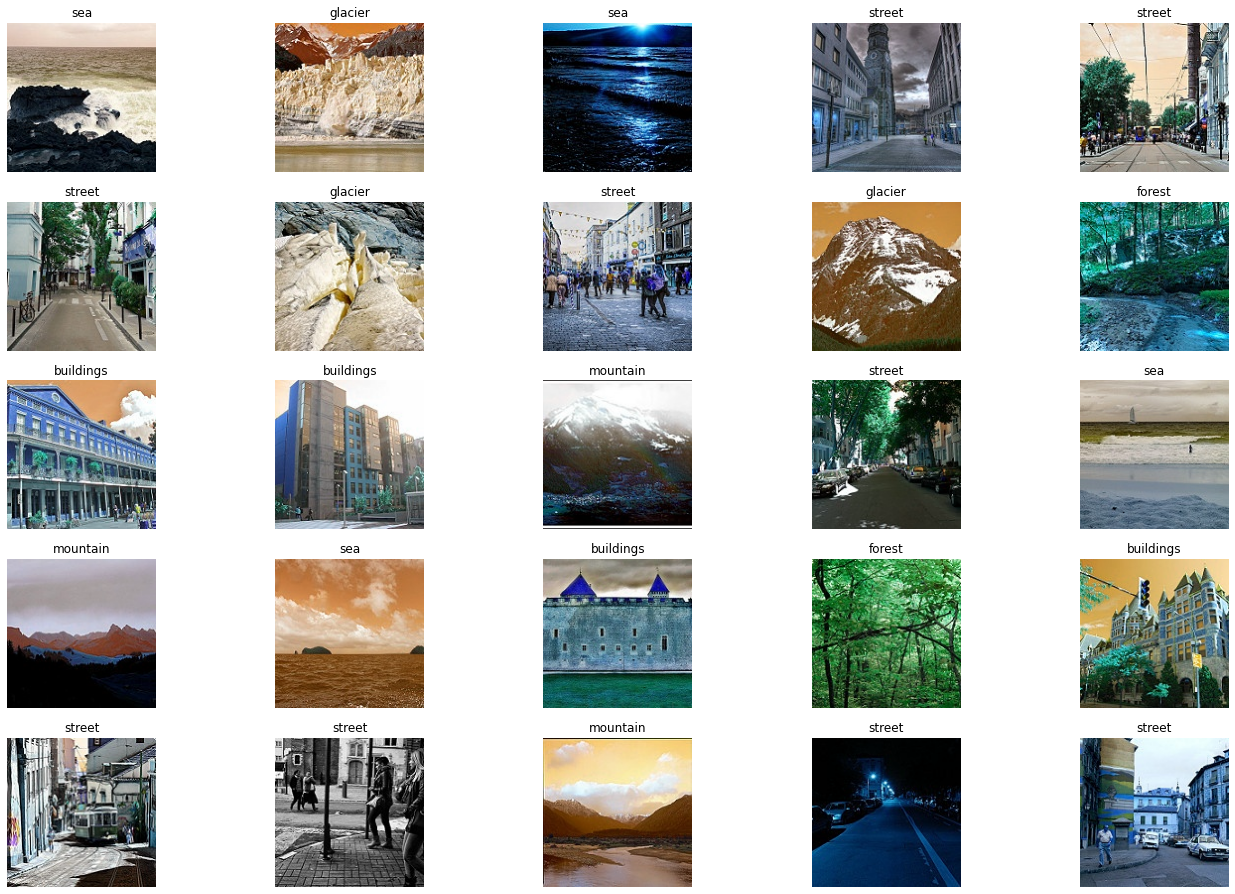

In [16]:
# Display a random of 25 images from training set
image_display(train_images, train_classes, 5, 5)

In [17]:
### CNN Model Development

train_label = encoder_label(train_classes)
train_label = np.array(train_label)
train_label
train_label.shape

(14034,)

In [18]:
# Developing CNN model for Image classification
cnn_model=Models.Sequential()

cnn_model.add(Layers.Conv2D(200,kernel_size=(3,3),activation='relu',input_shape=(150,150,3)))
cnn_model.add(Layers.Conv2D(180,kernel_size=(3,3),activation='relu'))
cnn_model.add(Layers.MaxPool2D(5,5))
cnn_model.add(Layers.Conv2D(180,kernel_size=(3,3),activation='relu'))
cnn_model.add(Layers.Conv2D(140,kernel_size=(3,3),activation='relu'))
cnn_model.add(Layers.Conv2D(100,kernel_size=(3,3),activation='relu'))
cnn_model.add(Layers.Conv2D(50,kernel_size=(3,3),activation='relu'))
cnn_model.add(Layers.MaxPool2D(5,5))
cnn_model.add(Layers.Flatten())
cnn_model.add(Layers.Dense(180,activation='relu'))
cnn_model.add(Layers.Dense(100,activation='relu'))
cnn_model.add(Layers.Dense(50,activation='relu'))
cnn_model.add(Layers.Dropout(rate=0.5))
cnn_model.add(Layers.Dense(6,activation='softmax'))

cnn_model.compile(optimizer=Optimizer.Adam(learning_rate=0.0001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])



In [19]:
#Summary of the model

cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 200)     5600      
                                                                 
 conv2d_1 (Conv2D)           (None, 146, 146, 180)     324180    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 29, 29, 180)      0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 27, 27, 180)       291780    
                                                                 
 conv2d_3 (Conv2D)           (None, 25, 25, 140)       226940    
                                                                 
 conv2d_4 (Conv2D)           (None, 23, 23, 100)       126100    
                                                        

In [20]:
#Validating CNN Model using 10 - cross validation
#model_history = n_fold_cross_validation(10, train_images, train_label, cnn_model)

#Number of epochs without any imporvement , after which the training will stop
epochs = 2 
#Defining the early stopping
stop_early = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

#history = cnn_model.fit(train_images, train_label, epochs=5, callbacks=[stop_early], validation_split=0.2 , verbose=1, validation_data = (train_images, train_label))



In [21]:
#10 fold cross validation
model_history = n_fold_cross_validation(10, train_images, train_label, cnn_model)

Fold currently training:  1
Epoch 1/20
395/395 [==============================] - 117s 260ms/step - loss: 1.4994 - accuracy: 0.4219 - val_loss: 1.4636 - val_accuracy: 0.2963
Epoch 2/20
395/395 [==============================] - 107s 270ms/step - loss: 1.0716 - accuracy: 0.5957 - val_loss: 1.4150 - val_accuracy: 0.3846
Epoch 3/20
395/395 [==============================] - 107s 272ms/step - loss: 0.8937 - accuracy: 0.6816 - val_loss: 1.2156 - val_accuracy: 0.5299
Epoch 4/20
395/395 [==============================] - 107s 271ms/step - loss: 0.7835 - accuracy: 0.7253 - val_loss: 1.0960 - val_accuracy: 0.6453
Epoch 5/20
395/395 [==============================] - 107s 272ms/step - loss: 0.7110 - accuracy: 0.7585 - val_loss: 1.4087 - val_accuracy: 0.4943
Epoch 6/20
395/395 [==============================] - 107s 271ms/step - loss: 0.6330 - accuracy: 0.7880 - val_loss: 1.0378 - val_accuracy: 0.6460
Epoch 7/20
395/395 [==============================] - 107s 271ms/step - loss: 0.5876 - accuracy:

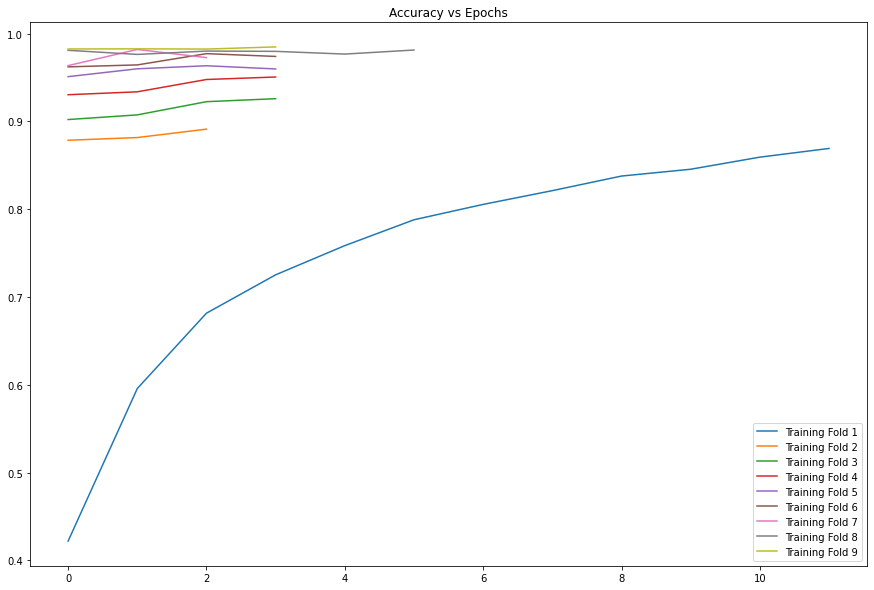

In [22]:
plt.figure(figsize=(15,10))
plt.title('Accuracy vs Epochs')
# plot_labels = 'Training Fold ' + i+1
for i in range(0,9):
  plt.plot(model_history[i].history['accuracy'], label='Training Fold '+str(i+1))

plt.legend() 
plt.show()

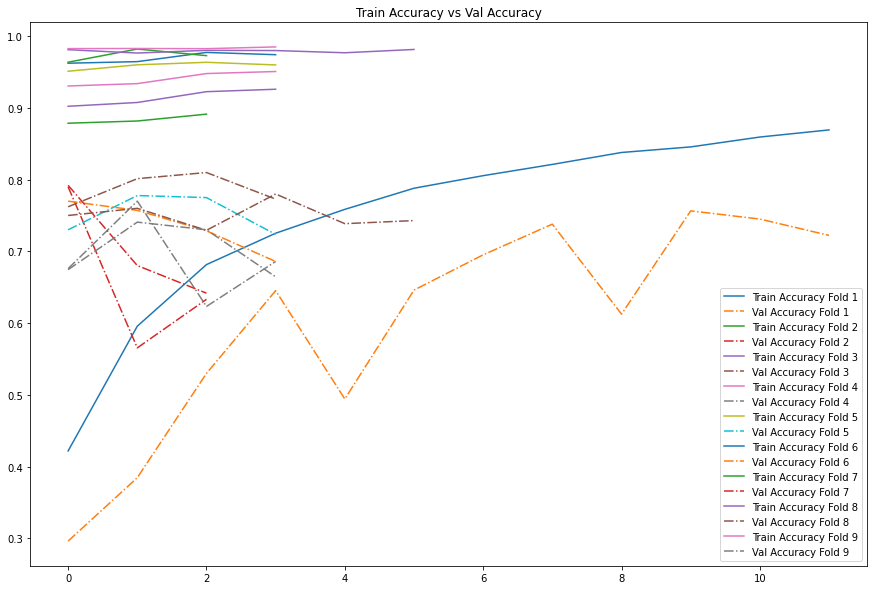

In [23]:
plt.figure(figsize=(15,10))
plt.title('Train Accuracy vs Val Accuracy')
for i in range(0,9):
  plt.plot(model_history[i].history['accuracy'], label='Train Accuracy Fold '+str(i+1))
  plt.plot(model_history[i].history['val_accuracy'], label='Val Accuracy Fold '+str(i+1), linestyle = "dashdot")
plt.legend()
plt.show()

In [24]:
# Validation with test data

# Model accuracy with test data

# Read test images and labels

#Check if file is a zipfile
val = zipfile.is_zipfile('/content/sample_data/seg_test.zip')

if (val == True):
  unzipfile('/content/sample_data/seg_test.zip')
else:
  print("Given file is not a zipfile")

# Training set read images
test_images, test_classes = image_read('/content/seg_test/seg_test', dir_image)

#test_images, test_classes= image_read('./seg_test', dir_image)

In [25]:
# Test images converted into numpy arrays
test_images = np.array(test_images)
test_classes = np.array(test_classes)

In [26]:
# We will check shape of images and labels
print('Shape of Images:', test_images.shape)
print('Shape of Classes:', test_classes.shape)

Shape of Images: (3000, 150, 150, 3)
Shape of Classes: (3000,)


In [27]:
# Encoding label for test classes
test_labels = encoder_label(test_classes)
test_labels = np.array(test_labels)

In [28]:
cnn_model.evaluate(test_images, test_labels)

94/94 [==============================] - 10s 104ms/step - loss: 1.4327 - accuracy: 0.8227


[1.432728886604309, 0.8226666450500488]

In [34]:
#Predicting the labels for the new data
#Check if file is a zipfile
val = zipfile.is_zipfile('/content/sample_data/seg_pred.zip')

if (val == True):
  unzipfile('/content/sample_data/seg_pred.zip')
else:
  print("Given file is not a zipfile")

pred_images, no_labels = image_read('/content/seg_pred/seg_pred', [])

In [42]:
pred_images = np.array(pred_images)
pred_images.shape


(7301, 150, 150, 3)

In [35]:
#get class label based on the classcode

def get_clabel(class_code):
    labels = { 0:'buildings',1:'forest', 4:'sea',   5:'street',2:'glacier', 3:'mountain'}
    
    return labels[class_code]

In [45]:
#Confusion Matrix of CNN model
predictions = cnn_model.predict(test_images) 

In [46]:
pred_labels = np.argmax(predictions, axis = 1) # We take the highest probability

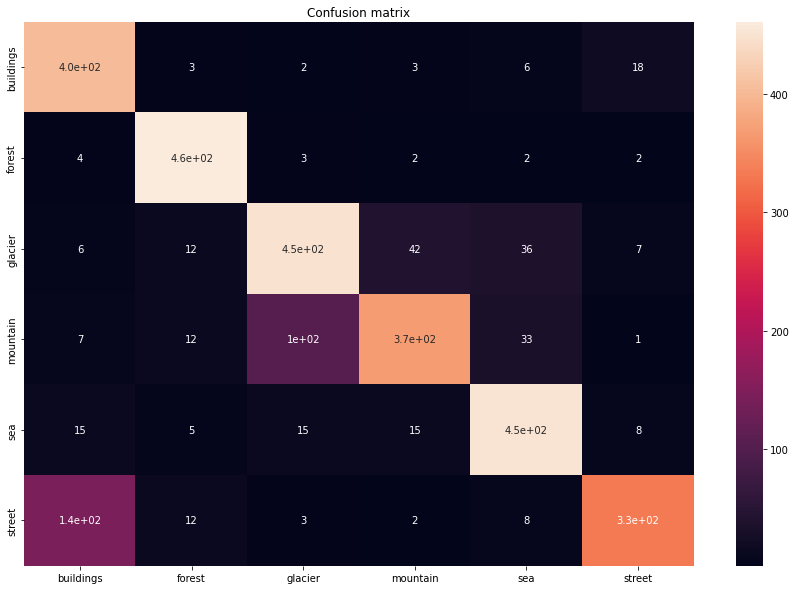

In [47]:
import sklearn.metrics as metrics
import seaborn as sn
CM = confusion_matrix(test_labels, pred_labels)
fig, ax = plt.subplots(figsize =(15,10))
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=dir_image, 
           yticklabels=dir_image, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

In [51]:
# Transfer learning of a pretrained model - Using VGG
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rescale=1/255.,
                            horizontal_flip=True,
                            width_shift_range=0.1,
                            height_shift_range=0.1)

test_datagen = ImageDataGenerator(rescale=1/255.)


In [52]:
d_input_shape = (150,150)
batch_size = 16
traingen = datagen.flow_from_directory('/content/seg_train/seg_train',
                                      target_size = d_input_shape,
                                      class_mode='categorical',
                                      batch_size=batch_size,
                                      shuffle=False)

testgen = test_datagen.flow_from_directory('/content/seg_test/seg_test',
                                      target_size = d_input_shape,
                                      class_mode='categorical',
                                      batch_size=batch_size,
                                      shuffle=False)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [53]:
vcg_model = Sequential()
L2 = tf.keras.regularizers.l2(0.001)
input_shape = (150,150,3)


vcg_model = tf.keras.applications.VGG19(include_top=False, input_shape=input_shape)
for layer in vcg_model.layers:
    layer.trainable=False
flat = Flatten()(vcg_model.layers[-1].output)
hidden1 = Dense(128,activation='relu')(flat)
output = Dense(6,activation='softmax')(hidden1)

vcg_model = Model(inputs=vcg_model.inputs, outputs=output)
vcg_model.summary()

80150528/80134624 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                              

In [54]:
vcg_model.compile(loss = 'categorical_crossentropy', optimizer= optimizers.Adam(0.001), metrics=['accuracy'])


In [55]:
history = vcg_model.fit(traingen,
                   epochs=10,
                   validation_data = testgen, )

Epoch 1/10
878/878 [==============================] - 117s 131ms/step - loss: 0.8101 - accuracy: 0.7026 - val_loss: 0.5343 - val_accuracy: 0.7880
Epoch 2/10
878/878 [==============================] - 105s 119ms/step - loss: 0.5093 - accuracy: 0.8074 - val_loss: 0.5092 - val_accuracy: 0.7933
Epoch 3/10
878/878 [==============================] - 103s 117ms/step - loss: 0.4558 - accuracy: 0.8278 - val_loss: 0.4100 - val_accuracy: 0.8530
Epoch 4/10
878/878 [==============================] - 104s 118ms/step - loss: 0.4255 - accuracy: 0.8412 - val_loss: 0.3974 - val_accuracy: 0.8563
Epoch 5/10
878/878 [==============================] - 104s 119ms/step - loss: 0.4071 - accuracy: 0.8473 - val_loss: 0.4235 - val_accuracy: 0.8443
Epoch 6/10
878/878 [==============================] - 103s 118ms/step - loss: 0.3819 - accuracy: 0.8538 - val_loss: 0.5393 - val_accuracy: 0.8090
Epoch 7/10
878/878 [==============================] - 104s 118ms/step - loss: 0.3698 - accuracy: 0.8601 - val_loss: 0.4153 -

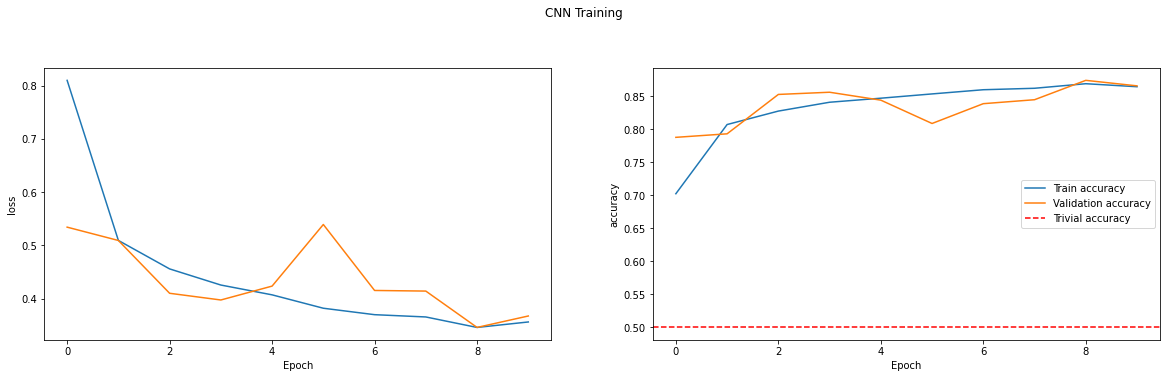

In [56]:
fig, ax = plt.subplots(1,2, figsize=(20,5))
for i, metric in enumerate(['loss', 'accuracy']): 
    ax[i].plot(history.history[metric], label=('Train '+metric))
    ax[i].plot(history.history['val_'+metric], label='Validation '+metric)
    if metric == 'accuracy': ax[i].axhline(0.5, c='r', ls='--', label='Trivial accuracy')
    ax[i].set_xlabel('Epoch')
    ax[i].set_ylabel(metric)
plt.suptitle('CNN Training', y=1.05)
plt.legend()

In [57]:
metric = vcg_model.evaluate(testgen)
print(f'Evaualtion loss : {metric[0]}')
print(f'Accuracy of Evaluation: {metric[1]:.2%}')

188/188 [==============================] - 10s 51ms/step - loss: 0.3673 - accuracy: 0.8660
Evaualtion loss : 0.36733126640319824
Accuracy of Evaluation: 86.60%
